# Are brains like faces?


Copyright 2019 Allen Downey

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

from warnings import simplefilter
simplefilter('ignore', FutureWarning)

Using TensorFlow backend.


Load the NKI SBA volume data, since it seems to have the most features with the highest Cohen effects.

In [2]:
df = pd.read_excel('brain_mosaic_data/NKI_SBA_Volume.xlsx')
df.head()

,bio_sex,age,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
0,2,41,5443,408,14526,47120,6506,2944,4535,1828,...,1151,13009,16499,10019,9201,7703,783,1945,923,6297
1,2,52,3228,309,13065,48090,6942,2918,5000,1734,...,1308,13780,18011,11602,12166,10272,747,1921,790,5537
2,2,54,5642,95,9687,38398,6385,2892,4351,1051,...,1903,13247,17477,10010,8808,8331,1193,2043,484,6033
3,2,56,4959,231,11442,41214,6195,3604,5135,1592,...,1753,12481,17378,9682,10091,9396,802,2336,799,6159
4,2,31,6664,161,12059,44711,6613,2981,4558,1462,...,1396,11924,21013,12134,10928,10362,699,2549,911,5853


Make the column names play nicely with StatsModels.

In [3]:
def clean_name(name):
    """Make column names play nicely with StatsModels.
    """
    name = name.replace('-', '_').lower()
    d = {'3rd_ventricle':'third_ventricle', '4th_ventricle':'fourth_ventricle'}
    return d.get(name, name)

In [4]:
columns = [clean_name(name) for name in df.columns]
df.columns = columns
df.head()

,bio_sex,age,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
0,2,41,5443,408,14526,47120,6506,2944,4535,1828,...,1151,13009,16499,10019,9201,7703,783,1945,923,6297
1,2,52,3228,309,13065,48090,6942,2918,5000,1734,...,1308,13780,18011,11602,12166,10272,747,1921,790,5537
2,2,54,5642,95,9687,38398,6385,2892,4351,1051,...,1903,13247,17477,10010,8808,8331,1193,2043,484,6033
3,2,56,4959,231,11442,41214,6195,3604,5135,1592,...,1753,12481,17378,9682,10091,9396,802,2336,799,6159
4,2,31,6664,161,12059,44711,6613,2981,4558,1462,...,1396,11924,21013,12134,10928,10362,699,2549,911,5853


Make a binary variable for StatsModels.

In [5]:
df['male'] = (df['bio_sex'] == 1).astype(int)
df['male'].mean()

0.3786764705882353

Select the volumetric features (I don't know what the other features are).

In [6]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

68

Compute total volume.

In [7]:
df['total_volume'] = df[features].sum(axis=1)
df['total_volume'].describe()

count       272.000000
mean     455371.117647
std       56890.820457
min      336198.000000
25%      416941.500000
50%      450121.000000
75%      489089.250000
max      684464.000000
Name: total_volume, dtype: float64

Make sure the new variables are on the feature list.

In [8]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

69

Distribution of volumes.

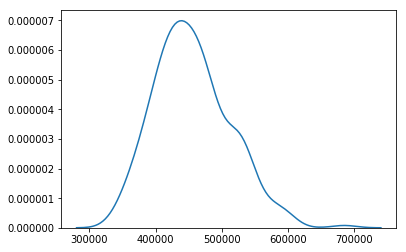

In [9]:
var = 'total_volume'
sns.kdeplot(df[var].values);

Distributions of total volume for male and female subjects.  As expected, men have bigger brains.

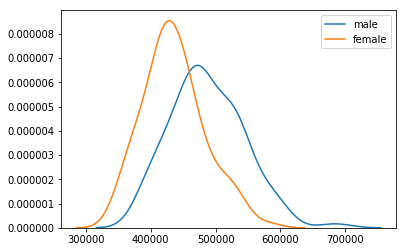

In [10]:
df['bio_sex'].replace(1, 0, inplace=True)
df['bio_sex'].replace(2, 1, inplace=True)

male = df['bio_sex'] == 0
female = df['bio_sex'] == 1

sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');

## Cohen effect size

Let's look for the features that show the biggest difference between men and women.

In [11]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's effect size (d).

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [12]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('male')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

Here are the top features by Cohen effect size.  The biggest difference is in total volume.  I suspect that the other top candidates are strongly correlated with total volume.

In [13]:
num_features = 12

res = compute_cohen_effect(df, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

total_volume                      0.998091
rh_superiorfrontal_volume         0.970546
rh_inferiortemporal_volume        0.964111
rh_lateraloccipital_volume        0.960110
rh_precuneus_volume               0.958064
lh_middletemporal_volume          0.953209
lh_superiorfrontal_volume         0.941572
lh_medialorbitofrontal_volume     0.937211
rh_rostralmiddlefrontal_volume    0.927699
lh_inferiortemporal_volume        0.909025
rh_fusiform_volume                0.890256
rh_lateralorbitofrontal_volume    0.874188
dtype: float64

In [14]:
def divide_by_vol(columns):
    for column in columns:
        df[column + '_norm'] = df[column]/df['total_volume']
        
columns = [name for name in df.columns if name.endswith('volume')]
divide_by_vol(columns)

In [15]:
df.drop('total_volume_norm', axis = 1)
features_norm = [name for name in df.columns if name.endswith('norm')]
len(features)

69

In [16]:
num_features = 12

res = compute_cohen_effect(df, features_norm)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_middletemporal_volume_norm          0.416500
rh_inferiortemporal_volume_norm        0.378245
lh_rostralmiddlefrontal_volume_norm    0.337220
rh_rostralmiddlefrontal_volume_norm    0.305688
rh_middletemporal_volume_norm          0.300476
lh_inferiortemporal_volume_norm        0.278646
lh_medialorbitofrontal_volume_norm     0.259600
rh_precuneus_volume_norm               0.249023
lh_parsorbitalis_volume_norm           0.234720
lh_supramarginal_volume_norm           0.205109
rh_parsorbitalis_volume_norm           0.189739
rh_inferiorparietal_volume_norm        0.184604
dtype: float64

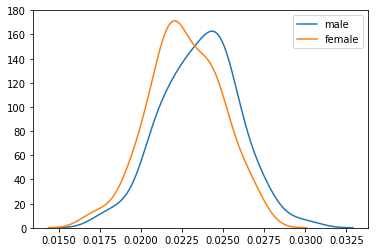

In [17]:
var = 'lh_middletemporal_volume_norm'
# sns.kdeplot(df[var].values);

sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');

R^2: 0.6707317073170732
Root Mean Squared Error: 0.5738190417570045
0.7215354586857515
[[15 14]
 [13 40]]


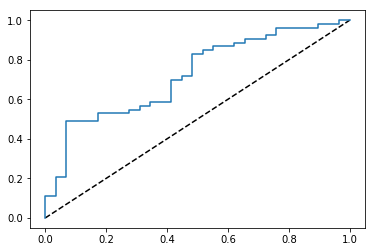

In [67]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

R^2: 0.6463414634146342
Root Mean Squared Error: 0.59469196781642
0.7807417046193884
[[ 0 29]
 [ 0 53]]


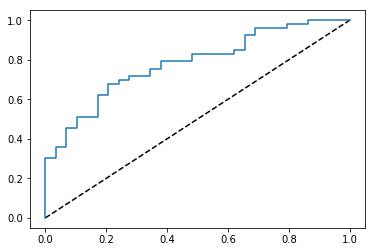

In [19]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [20]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

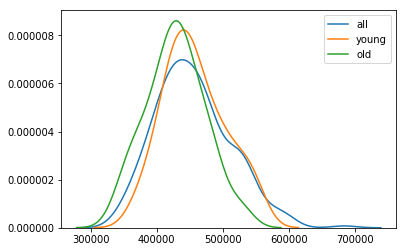

In [35]:
var = 'total_volume'
sns.kdeplot(df[var].values, label='all');

young = (df['age'] <= 49) & (df ['age'] >= 26)
old = (df['age'] >= 49) & (df['age'] <= 60)

sns.kdeplot(df.loc[young, var], label='young')
sns.kdeplot(df.loc[old, var], label='old');

In [41]:
conditions = [
    (df['age'] <= 49) & (df['age'] >= 26),
    (df['age'] <= 60) & (df['age'] >= 49)]
choices = [1, 0]
df['young'] = np.select(conditions, choices, default=np.nan)
df['young'].mean()

0.5704225352112676

In [1]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [2]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

NameError: name 'df' is not defined

In [44]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_rostralmiddlefrontal_volume_norm    0.475797
lh_parstriangularis_volume_norm        0.404769
rh_parsopercularis_volume_norm         0.342945
rh_transversetemporal_volume_norm      0.319506
rh_parstriangularis_volume_norm        0.311488
rh_inferiorparietal_volume_norm        0.301266
lh_middletemporal_volume_norm          0.300623
rh_posteriorcingulate_volume_norm      0.299719
rh_bankssts_volume_norm                0.296518
lh_parsopercularis_volume_norm         0.234782
lh_caudalmiddlefrontal_volume_norm     0.228521
lh_lateralorbitofrontal_volume_norm    0.225363
dtype: float64

R^2: 0.5348837209302325
Root Mean Squared Error: 0.6819943394704735
0.5326086956521738
[[ 0 20]
 [ 0 23]]


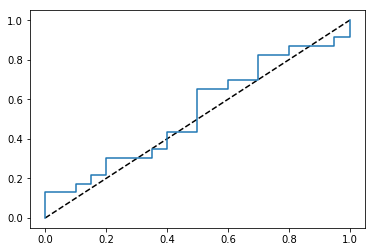

In [59]:
features_norm.append('young')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [20]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

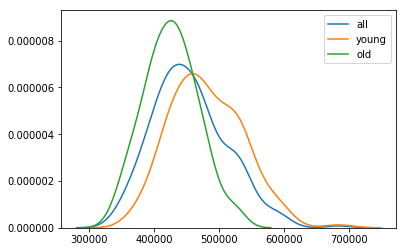

In [60]:
var = 'total_volume'
sns.kdeplot(df[var].values, label='all');

young2 = df['age'] <= 49
old2 = df['age'] >= 49

sns.kdeplot(df.loc[young2, var], label='young')
sns.kdeplot(df.loc[old2, var], label='old');

In [62]:
conditions = [
    (df['age'] <= 49),
    (df['age'] >= 49)]
choices = [1, 0]
df['young2'] = np.select(conditions, choices, default=np.nan)
df['young2'].mean()

0.5367647058823529

In [63]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young2')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [64]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

lh_superiorfrontal_volume         1.192475
lh_lateralorbitofrontal_volume    1.145116
rh_superiorfrontal_volume         1.126841
lh_rostralmiddlefrontal_volume    1.125618
total_volume                      1.116835
rh_bankssts_volume                1.089253
lh_parstriangularis_volume        1.079199
rh_parsopercularis_volume         1.071623
rh_inferiorparietal_volume        1.066946
lh_middletemporal_volume          1.063581
rh_parstriangularis_volume        1.044952
rh_lateralorbitofrontal_volume    1.027525
dtype: float64

In [65]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_rostralmiddlefrontal_volume_norm    0.629192
rh_bankssts_volume_norm                0.493653
rh_parsopercularis_volume_norm         0.466349
lh_middletemporal_volume_norm          0.461419
lh_parstriangularis_volume_norm        0.457526
rh_inferiorparietal_volume_norm        0.400318
rh_middletemporal_volume_norm          0.389172
rh_parstriangularis_volume_norm        0.375779
lh_superiorfrontal_volume_norm         0.374386
rh_parsorbitalis_volume_norm           0.352402
lh_bankssts_volume_norm                0.323629
lh_superiortemporal_volume_norm        0.296492
dtype: float64

R^2: 0.5853658536585366
Root Mean Squared Error: 0.6439209162167846
0.7481617647058824
[[ 0 34]
 [ 0 48]]


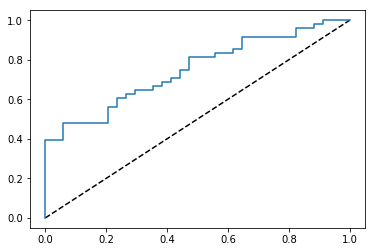

In [66]:
features_norm.append('young2')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young2']
X = temp.drop('young2', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [151]:
df_1000 = pd.read_excel('brain_mosaic_data/1000_Connectomes_age_18-26_VBM.xlsx')
df_1000.head()

,bio_sex,age,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Cerebelum_00_L,Cerebelum_00_R,Vermis_0_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_00
0,1,18,0.436035,0.406023,0.361779,0.369537,0.495171,0.479090,0.420118,0.444269,...,0.257104,0.247064,0.431084,0.471217,0.572555,0.590969,0.575713,0.558999,0.524192,0.226187
1,1,18,0.422395,0.430086,0.383270,0.390875,0.477471,0.450275,0.448891,0.460303,...,0.245738,0.197609,0.383902,0.421114,0.501804,0.560840,0.566743,0.572814,0.505971,0.202734
2,1,18,0.439540,0.430842,0.385297,0.376834,0.520610,0.472500,0.454426,0.417339,...,0.245801,0.246097,0.418835,0.424117,0.510495,0.597151,0.604129,0.618324,0.606951,0.285061
3,1,18,0.473102,0.449665,0.416976,0.417434,0.536880,0.532697,0.471110,0.502046,...,0.215978,0.202993,0.395247,0.431441,0.524903,0.577355,0.629283,0.642825,0.570416,0.231166
4,1,18,0.382771,0.380443,0.347929,0.359899,0.463163,0.453011,0.393531,0.393259,...,0.236000,0.277785,0.370647,0.434968,0.583758,0.564699,0.543617,0.546831,0.565252,0.247790


In [152]:
df_1000.columns

Index(['bio_sex', 'age', 'Precentral_L', 'Precentral_R', 'Frontal_Sup_L',
       'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R',
       'Frontal_Mid_L', 'Frontal_Mid_R',
       ...
       'Cerebelum_00_L', 'Cerebelum_00_R', 'Vermis_0_2', 'Vermis_3',
       'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9',
       'Vermis_00'],
      dtype='object', length=118)

In [153]:
df_1000['bio_sex'].value_counts()

2    385
1    240
Name: bio_sex, dtype: int64

In [154]:
df_1000['bio_sex'].replace(1, 0, inplace=True)
df_1000['bio_sex'].replace(2, 1, inplace=True)

male = df_1000['bio_sex'] == 0
female = df_1000['bio_sex'] == 1

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
595     True
596     True
597     True
598     True
599     True
600     True
601     True
602     True
603     True
604     True
605     True
606     True
607     True
608     True
609     True
610     True
611     True
612     True
613     True
614     True
615     True
616     True
617     True
618     True
619     True
620     True
621     True
622     True
623     True
624     True
Name: bio_sex, Length: 625, dtype: bool

0.0    272
Name: male, dtype: int64

Distributions of total volume for male and female subjects.  As expected, men have bigger brains.

## Cohen effect size

Let's look for the features that show the biggest difference between men and women.

In [155]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's effect size (d).

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [156]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('bio_sex')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

Here are the top features by Cohen effect size.  The biggest difference is in total volume.  I suspect that the other top candidates are strongly correlated with total volume.

In [157]:
num_features = 12
features = list(df_1000.drop(['age', 'bio_sex'], axis=1).columns)

res = compute_cohen_effect(df_1000, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

Vermis_7             0.601494
Hippocampus_R        0.576675
Caudate_L            0.537445
Cerebelum_Crus2_R    0.503056
Postcentral_R        0.488203
Hippocampus_L        0.462809
Frontal_Inf_Orb_L    0.456477
Frontal_Sup_Orb_L    0.455499
Cerebelum_Crus2_L    0.449714
Parietal_Inf_R       0.429542
Postcentral_L        0.427087
Frontal_Mid_Orb_L    0.425625
dtype: float64

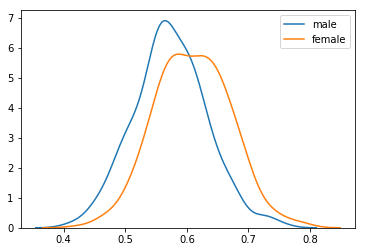

In [158]:
var = 'Vermis_7'
sns.kdeplot(df_1000.loc[male, var], label='male')
sns.kdeplot(df_1000.loc[female, var], label='female');

R^2: 0.6276595744680851
Root Mean Squared Error: 0.6101970382851059
0.727038727038727
[[ 15  62]
 [  8 103]]


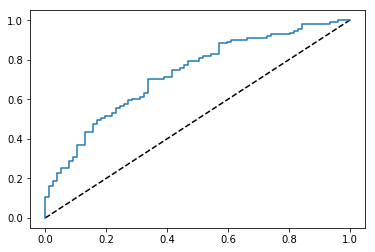

In [159]:
features.append('bio_sex')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features.pop()

y = temp['bio_sex']
X = temp.drop('bio_sex', axis=1)

# temp['bio_sex'].value_counts()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [160]:
df_1000['age'].describe()

count    625.000000
mean      21.516800
std        1.975034
min       18.000000
25%       20.000000
50%       21.000000
75%       23.000000
max       26.000000
Name: age, dtype: float64

In [172]:
conditions = [
    (df_1000['age'] <= 21),
    (df_1000['age'] > 21)]
choices = [1, 0]
df_1000['young'] = np.select(conditions, choices, default=np.nan)
df_1000['young'].mean()

0.5456

In [173]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [174]:
num_features = 12

res = compute_cohen_effect_age(df_1000, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


young                   inf
Insula_R           0.436826
Precentral_R       0.410753
Insula_L           0.374693
Frontal_Mid_R      0.372729
Temporal_Inf_R     0.359378
Temporal_Mid_R     0.341947
Frontal_Mid_L      0.339900
Parietal_Inf_R     0.336717
Rolandic_Oper_R    0.332593
Fusiform_R         0.326248
Heschl_R           0.323768
dtype: float64

R^2: 0.5212765957446809
Root Mean Squared Error: 0.6918984060216639
0.5644459706959708
[[26 58]
 [32 72]]


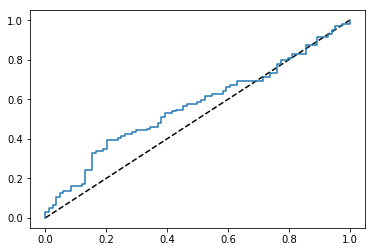

In [178]:
features.append('young')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features_norm.pop()

y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))